In [1]:
import numpy as np
import pandas as pd
import os
import sys
import torch
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tqdm import tqdm

sys.path.append('../')
from preprocess import SkeletonDataset

# Input space

### SC

In [2]:
data_dir = '/neurospin/dico/lguillon/distmap/data/'
filenames = np.load(os.path.join(data_dir, "train_sub_id.npy"))
distmaps = np.load(os.path.join(data_dir, "train_distmap.npy"), mmap_mode='r')

In [4]:
X = np.array([distmaps[k].flatten() for k in range(len(distmaps))])

X_embedded = TSNE(n_components=2).fit_transform(X)

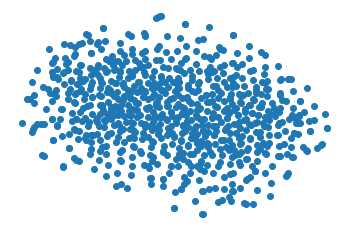

In [5]:
arr = X_embedded

fig = plt.figure()
ax = fig.add_subplot(111)

x = [arr[k][0] for k in range(len(arr))]
y = [arr[k][1] for k in range(len(arr))]
ax.scatter(x, y)

plt.axis('off')    

plt.show()

### Pre / post central avant application du masque

In [3]:
## Precentral
benchmark_dir = '/neurospin/dico/data/deep_folding/current/datasets/hcp/crops/1mm/precentral/no_mask/benchmark/'
distmaps_pre = np.load(os.path.join(benchmark_dir, "distmap_1mm.npy"), mmap_mode='r')
filenames_pre = np.load(os.path.join(data_dir, "train_sub_id.npy"))

df = pd.read_csv(data_dir+'train_list.csv')
train_list = np.array(list(df.subjects))
distmaps_pre = np.load(os.path.join(benchmark_dir, "distmap_1mm.npy"),
                       mmap_mode='r')
filenames_pre = np.load(os.path.join(data_dir, "train_sub_id.npy"))

sorter = np.argsort(filenames_pre)
filenames_idx_pre = sorter[np.searchsorted(filenames_pre, train_list, sorter=sorter)]
filenames_pre = filenames_pre[filenames_idx_pre]
distmaps_pre = distmaps_pre[filenames_idx_pre]

In [4]:
## Postcentral
benchmark_dir = '/neurospin/dico/data/deep_folding/current/datasets/hcp/crops/1mm/postcentral/no_mask/benchmark/'
distmaps_post = np.load(os.path.join(benchmark_dir, "distmap_1mm.npy"), mmap_mode='r')
filenames_post = np.load(os.path.join(data_dir, "train_sub_id.npy"))

benchmark_dir = '/neurospin/dico/data/deep_folding/current/datasets/hcp/crops/1mm/postcentral/no_mask/benchmark/'
distmaps_post = np.load(os.path.join(benchmark_dir, "distmap_1mm.npy"),
                       mmap_mode='r')
filenames_post = np.load(os.path.join(data_dir, "train_sub_id.npy"))

sorter = np.argsort(filenames_post)
filenames_idx_post = sorter[np.searchsorted(filenames_post, train_list, sorter=sorter)]
filenames_post = filenames_post[filenames_idx_post]
distmaps_post = distmaps_post[filenames_idx_post]

In [5]:
X = np.array([distmaps[k].flatten() for k in range(len(distmaps))] + [distmaps_pre[k].flatten() for k in range(len(distmaps_pre))]+ [distmaps_post[k].flatten() for k in range(len(distmaps_post))])
X_embedded = TSNE(n_components=2).fit_transform(X)
label = ['SC' for k in range(len(distmaps))] + ['pre' for k in range(len(distmaps_pre))] + ['post' for k in range(len(distmaps_post))]

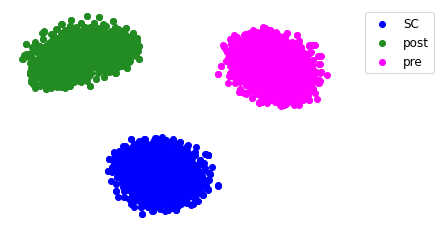

In [6]:
color_dict = {'SC': 'blue', 'pre': 'magenta', 'post': 'forestgreen'}
arr = X_embedded

fig = plt.figure()
ax = fig.add_subplot(111)

for g in np.unique(label):
    ix = np.where(np.array(label) == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    ax.scatter(x, y, c = color_dict[g], label = g)


plt.axis('off')    
ax.legend(fontsize=12)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)

plt.show()

### Pre / post central avec application du masque et normalisation (tels qu'ils sont donnés au modèle)

In [7]:
subset_sc = SkeletonDataset(dataframe=distmaps, filenames=filenames, data_transforms=False)
subset_pre = SkeletonDataset(dataframe=distmaps_pre, filenames=filenames_pre, data_transforms=False)
subset_post = SkeletonDataset(dataframe=distmaps_post, filenames=filenames_post, data_transforms=False)

In [8]:
sc_loader = torch.utils.data.DataLoader(
                          subset_sc,
                          batch_size=801,
                          num_workers=8,
                          shuffle=False)

pre_loader = torch.utils.data.DataLoader(
                          subset_pre,
                          batch_size=801,
                          num_workers=8,
                          shuffle=False)

post_loader = torch.utils.data.DataLoader(
                           subset_post,
                           batch_size=801,
                           num_workers=8,
                           shuffle=False)

In [9]:
dico_set_loaders = {'sc': sc_loader,
                    'benchmark_pre': pre_loader,
                    'benchmark_post': post_loader}

In [16]:
for inputs, path in tqdm(sc_loader):
    X_sc_preprocessed = inputs

100%|██████████| 1/1 [00:57<00:00, 57.18s/it]


In [12]:
for inputs, path in tqdm(pre_loader):
    X_pre_preprocessed = inputs

100%|██████████| 1/1 [00:58<00:00, 58.54s/it]


In [13]:
for inputs, path in tqdm(post_loader):
    X_post_preprocessed = inputs

100%|██████████| 1/1 [00:59<00:00, 59.94s/it]


In [17]:
X_sc_preprocessed = X_sc_preprocessed.numpy().squeeze()
X_pre_preprocessed = X_pre_preprocessed.numpy().squeeze()
X_post_preprocessed = X_post_preprocessed.numpy().squeeze()

In [18]:
X_proc = np.array([X_sc_preprocessed[k].flatten() for k in range(len(X_sc_preprocessed))] + [X_pre_preprocessed[k].flatten() for k in range(len(X_pre_preprocessed))]+ [X_post_preprocessed[k].flatten() for k in range(len(X_post_preprocessed))])
X_embedded_proc = TSNE(n_components=2).fit_transform(X_proc)
label = ['SC' for k in range(len(X_sc_preprocessed))] + ['pre' for k in range(len(X_pre_preprocessed))] + ['post' for k in range(len(X_post_preprocessed))]

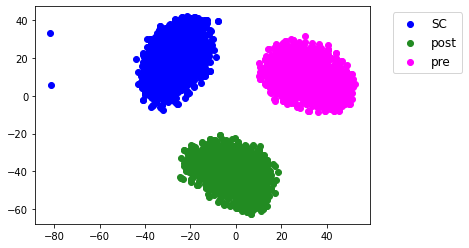

In [19]:
#label = ['SC' for k in range(len(X_sc_preprocessed))] + ['pre' for k in range(len(X_pre_preprocessed))] + ['post' for k in range(len(X_post_preprocessed))]
color_dict = {'SC': 'blue', 'pre': 'magenta', 'post': 'forestgreen'}
arr = X_embedded_proc

fig = plt.figure()
ax = fig.add_subplot(111)

for g in np.unique(label):
    ix = np.where(np.array(label) == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    ax.scatter(x, y, c = color_dict[g], label = g)


#plt.axis('off')    
ax.legend(fontsize=12)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)

plt.show()

#### Avec rotations

In [20]:
subset_sc = SkeletonDataset(dataframe=distmaps, filenames=filenames, data_transforms=True)
subset_pre = SkeletonDataset(dataframe=distmaps_pre, filenames=filenames_pre, data_transforms=True)
subset_post = SkeletonDataset(dataframe=distmaps_post, filenames=filenames_post, data_transforms=True)

In [21]:
sc_loader = torch.utils.data.DataLoader(
                          subset_sc,
                          batch_size=801,
                          num_workers=8,
                          shuffle=False)

pre_loader = torch.utils.data.DataLoader(
                          subset_pre,
                          batch_size=801,
                          num_workers=8,
                          shuffle=False)

post_loader = torch.utils.data.DataLoader(
                           subset_post,
                           batch_size=801,
                           num_workers=8,
                           shuffle=False)

In [22]:
dico_set_loaders = {'sc': sc_loader,
                    'benchmark_pre': pre_loader,
                    'benchmark_post': post_loader}

In [23]:
for inputs, path in tqdm(sc_loader):
    X_sc_preprocessed = inputs

100%|██████████| 1/1 [03:09<00:00, 189.82s/it]


In [24]:
for inputs, path in tqdm(pre_loader):
    X_pre_preprocessed = inputs

100%|██████████| 1/1 [03:12<00:00, 192.60s/it]


In [25]:
for inputs, path in tqdm(post_loader):
    X_post_preprocessed = inputs

100%|██████████| 1/1 [03:11<00:00, 191.28s/it]


In [26]:
X_sc_preprocessed = X_sc_preprocessed.numpy().squeeze()
X_pre_preprocessed = X_pre_preprocessed.numpy().squeeze()
X_post_preprocessed = X_post_preprocessed.numpy().squeeze()

In [27]:
X_proc = np.array([X_sc_preprocessed[k].flatten() for k in range(len(X_sc_preprocessed))] + [X_pre_preprocessed[k].flatten() for k in range(len(X_pre_preprocessed))]+ [X_post_preprocessed[k].flatten() for k in range(len(X_post_preprocessed))])
X_embedded_proc = TSNE(n_components=2).fit_transform(X_proc)
label = ['SC' for k in range(len(X_sc_preprocessed))] + ['pre' for k in range(len(X_pre_preprocessed))] + ['post' for k in range(len(X_post_preprocessed))]

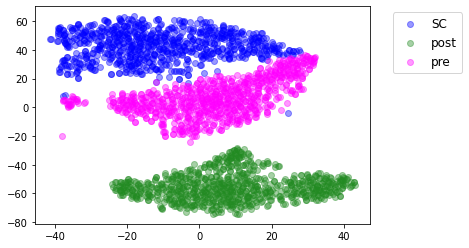

In [40]:
#label = ['SC' for k in range(len(X_sc_preprocessed))] + ['pre' for k in range(len(X_pre_preprocessed))] + ['post' for k in range(len(X_post_preprocessed))]
color_dict = {'SC': 'blue', 'pre': 'magenta', 'post': 'forestgreen'}
arr = X_embedded_proc

fig = plt.figure()
ax = fig.add_subplot(111)

for g in np.unique(label):
    ix = np.where(np.array(label) == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    ax.scatter(x, y, c = color_dict[g], label = g, alpha=0.4)

#plt.axis('off')    
ax.legend(fontsize=12)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)

plt.show()

In [41]:
from scipy.stats import mannwhitneyu, ttest_ind
ttest_ind(X_embedded_proc[:801], X_embedded_proc[801:1602])

Ttest_indResult(statistic=array([-18.363771,  63.91215 ], dtype=float32), pvalue=array([1.69645265e-68, 0.00000000e+00]))

In [42]:
ttest_ind(X_embedded_proc[:801], X_embedded_proc[1602:])

Ttest_indResult(statistic=array([-24.234943, 203.53986 ], dtype=float32), pvalue=array([8.88662035e-111, 0.00000000e+000]))

#### Rotations only on SC

In [43]:
subset_sc = SkeletonDataset(dataframe=distmaps, filenames=filenames, data_transforms=True)
subset_pre = SkeletonDataset(dataframe=distmaps_pre, filenames=filenames_pre, data_transforms=False)
subset_post = SkeletonDataset(dataframe=distmaps_post, filenames=filenames_post, data_transforms=False)

In [44]:
sc_loader = torch.utils.data.DataLoader(
                          subset_sc,
                          batch_size=801,
                          num_workers=8,
                          shuffle=False)

pre_loader = torch.utils.data.DataLoader(
                          subset_pre,
                          batch_size=801,
                          num_workers=8,
                          shuffle=False)

post_loader = torch.utils.data.DataLoader(
                           subset_post,
                           batch_size=801,
                           num_workers=8,
                           shuffle=False)

In [45]:
dico_set_loaders = {'sc': sc_loader,
                    'benchmark_pre': pre_loader,
                    'benchmark_post': post_loader}

In [46]:
for inputs, path in tqdm(sc_loader):
    X_sc_preprocessed = inputs

100%|██████████| 1/1 [05:39<00:00, 339.62s/it]


In [47]:
for inputs, path in tqdm(pre_loader):
    X_pre_preprocessed = inputs

100%|██████████| 1/1 [01:06<00:00, 66.82s/it]


In [48]:
for inputs, path in tqdm(post_loader):
    X_post_preprocessed = inputs

100%|██████████| 1/1 [01:07<00:00, 67.49s/it]


In [49]:
X_sc_preprocessed = X_sc_preprocessed.numpy().squeeze()
X_pre_preprocessed = X_pre_preprocessed.numpy().squeeze()
X_post_preprocessed = X_post_preprocessed.numpy().squeeze()

In [50]:
X_proc = np.array([X_sc_preprocessed[k].flatten() for k in range(len(X_sc_preprocessed))] + [X_pre_preprocessed[k].flatten() for k in range(len(X_pre_preprocessed))]+ [X_post_preprocessed[k].flatten() for k in range(len(X_post_preprocessed))])
X_embedded_proc = TSNE(n_components=2).fit_transform(X_proc)
label = ['SC' for k in range(len(X_sc_preprocessed))] + ['pre' for k in range(len(X_pre_preprocessed))] + ['post' for k in range(len(X_post_preprocessed))]

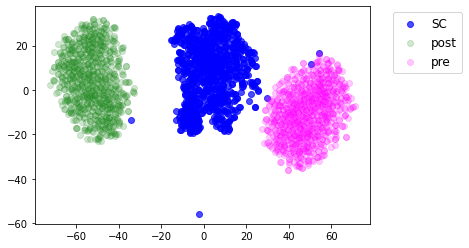

In [55]:
#label = ['SC' for k in range(len(X_sc_preprocessed))] + ['pre' for k in range(len(X_pre_preprocessed))] + ['post' for k in range(len(X_post_preprocessed))]
color_dict = {'SC': 'blue', 'pre': 'magenta', 'post': 'forestgreen'}
arr = X_embedded_proc

fig = plt.figure()
ax = fig.add_subplot(111)

for g in np.unique(label):
    ix = np.where(np.array(label) == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    if g=='SC':
        ax.scatter(x, y, c = color_dict[g], label = g, alpha=0.7)
    else:
        ax.scatter(x, y, c = color_dict[g], label = g, alpha=0.2)

#plt.axis('off')    
ax.legend(fontsize=12)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)

plt.show()